In [2]:
%matplotlib inline
import h5py as hp
import numpy as np
from machine_data import v2366_v2
from FITX import fit_risetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *
from FITX import fit_risetime
from machine_data.TDR2 import *
from postprocessing import *
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from machine_data.soleil import v2366, v2366_v2

/home/gubaidulin/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/gubaidulin/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
n_macroparticles = 1e5
n_turns = 5e4
n_turns_wake = 50
Qp_x = 1.6
Qp_y = 1.6
id_state = 'open'
include_Zlong = 'True'
harmonic_cavity = 'False'
bunch_current = 1.2e-3
max_kick = 3.2e-6
folder = '/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/fbt/'
f = hp.File(folder+
            f'monitors(n_mp={n_macroparticles:.1e},'+
            f'n_turns={n_turns:.1e},'+
            f'n_bin=100,bunch_current={bunch_current:.1e},'+
            f'Qp_x={Qp_x:.2f},Qp_y={Qp_y:.2f},ID_state={id_state:},'+
            f'include_Zlong={include_Zlong:},'+
            f'harmonic_cavity={harmonic_cavity:},'+
            f'n_turns_wake={n_turns_wake:},'+
            f'max_kick={max_kick:.1e}'+
            ').hdf5'
# 'monitors(n_mp=1.0e+05,n_turns=5.0e+04,n_bin=100,bunch_current=6.3e-03,Qp_x=1.60,Qp_y=1.60,id_state=open,Zlong=True,cavity=False,max_kick=8.0e-07).hdf5'
           )
y = f['Beam']['mean'][2, :, :].flatten(order='F')
yp = f['Beam']['mean'][3, :, :].flatten(order='F')
Jy = f['Beam']['cs_invariant'][1, :, :].flatten(order='F')
y = np.trim_zeros(y)
yp = np.trim_zeros(yp)

sig_y = f['Beam']['std'][2, 0 , 0]
turns = np.linspace(0, n_turns, y.shape[0])
fig, ax = plt.subplots(1, 1)

risetime = plot_offset(ax,
            m=y,
            mp=yp,
            std=sig_y,
            n_macroparticles=n_macroparticles,
            n_turns=n_turns,
            n_bin=100,
            bunch_current=bunch_current,
            Qp_x=1.6,
            Qp_y=1.6,
            n_bunches=416,
            n_sampling = 10)
dQcoh = 1/(2*np.pi*risetime)
ring = v2366_v2(IDs=id_state)
dQrad = 1/(ring.tau[1]*ring.omega0)
print(f'Threshold current is {500/dQcoh*dQrad:.1f} mA')
print(f'Synchrotron period in turns {1/(2*np.pi*ring.synchrotron_tune(1.8e6)):.1f}')
# ax.set_xlim(0, 2e4)
# ax.set_ylim(-1e4, 1e4)
# plt.savefig(f'/home/gubaidulin/scripts/tracking/transverse_instabilities/data/processed/offset(Qp={Qp_y:.1f},n_turns_wake={n_turns_wake:}).png')

Threshold current is nan mA
Synchrotron period in turns 75.2


In [6]:

# y1, sig_y1, Jy1 = y, sig_y, Jy
y2, sig_y2, Jy2 = y, sig_y, Jy
# y3, sig_y3, Jy3 = y, sig_y, Jy

1023.1378203287006
nan


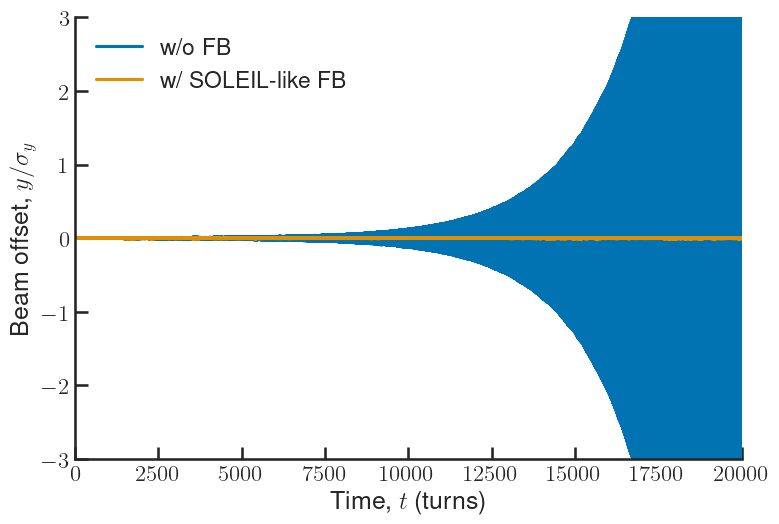

In [8]:
# Jy = np.trim_zeros(Jy)
time = np.linspace(0, len(Jy)/416, len(Jy))
fig, ax = plt.subplots(1, 1)
labels=['w/o FB', 'w/ SOLEIL-like FB']
for i, (y, sig_y, Jy) in enumerate([(y1, sig_y1, Jy1), (y2, sig_y2, Jy2)]):
    ax.plot(time, y/sig_y, label=labels[i])
    rx = fit_risetime(Jy/sig_y, min_level=1e-4, matplotlib_axis=None)
    print(rx/416)
ax.legend(loc='upper left')
ax.set_xlim(0, 20_000)
ax.set_ylim(-3, 3)
ax.set_xlabel('Time, $t$ (turns)')
ax.set_ylabel('Beam offset, $y/\sigma_y$')
# ax.title.set_text(f'Risetime {rx/416:.1f}')
ax.title.set_text('')

178.2857142857143

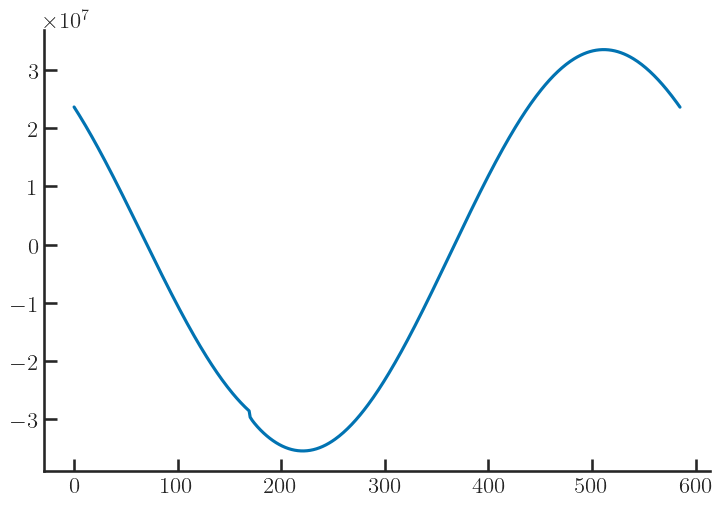

In [24]:
plt.plot(y[-(416+170):]/sig_y)
(1/0.7-1)*416

In [6]:
sample_freq = 416
fft = np.abs(np.fft.rfft(y[:]))
fftfreq = sample_freq*np.fft.rfftfreq(y[:].shape[0])

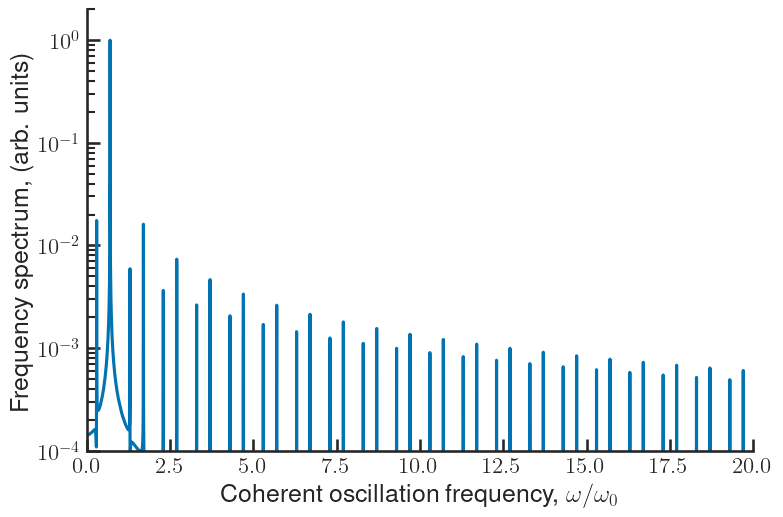

In [7]:
fig, ax = plt.subplots(1, 1)

ax.semilogy(fftfreq, fft/np.max(fft))
ax.set_xlim(0, 20)
ax.set_ylim(1e-4, )
ax.set_xlabel('Coherent oscillation frequency, $\omega/\omega_0$')
ax.set_ylabel('Frequency spectrum, (arb. units)')
plt.savefig(f'/home/gubaidulin/scripts/tracking/transverse_instabilities/data/processed/spectrum(Qp={Qp_y:.1f},n_turns_wake={n_turns_wake:}).png')